## Imports

In [1]:

import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from graphs import plot_correlation_matrix

import torch
from torchvision import datasets, transforms

#quanutm lib
import pennylane as qml
from pennylane import numpy as np

from pennylane.optimize import AdamOptimizer

import torch
from torchvision import datasets, transforms

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\tomut\anaconda3\envs\qhack2022\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
import sys
sys.path.append("..") # Adds higher directory to python modules path

from qencode.initialize import setAB_amplitude, setAux, setEnt
from qencode.encoders import e5_patch
from qencode.training_circuits import swap_t
from qencode.qubits_arrangement import QubitsArrangement

from qencode.utils.mnist import get_dataset

## Data

In [3]:
df=pd.read_csv("cancer.csv", nrows=500)
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


In [4]:
## malign and benign aee reverted !!!!!!!!!!!!!

diagnosis=[]
for d in df.diagnosis:
    if d=="M":
        diagnosis.append(1.0)
    else:
        diagnosis.append(0.0)
df["diagnosis"]=diagnosis

In [5]:
print('Malign: ', df['diagnosis'].value_counts()[0])
print('Benign: ', df['diagnosis'].value_counts()[1])

Malign:  305
Benign:  195


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       500 non-null    int64  
 1   diagnosis                500 non-null    float64
 2   radius_mean              500 non-null    float64
 3   texture_mean             500 non-null    float64
 4   perimeter_mean           500 non-null    float64
 5   area_mean                500 non-null    float64
 6   smoothness_mean          500 non-null    float64
 7   compactness_mean         500 non-null    float64
 8   concavity_mean           500 non-null    float64
 9   concave points_mean      500 non-null    float64
 10  symmetry_mean            500 non-null    float64
 11  fractal_dimension_mean   500 non-null    float64
 12  radius_se                500 non-null    float64
 13  texture_se               500 non-null    float64
 14  perimeter_se             5

In [7]:
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0
mean,3.263049e+07,0.390000,14.224206,19.086320,92.606620,662.844800,0.095978,0.103948,0.089941,0.049446,...,25.508500,108.258320,896.003200,0.131972,0.256324,0.276420,0.115980,0.292212,0.083778,NaN
std,1.326933e+08,0.488238,3.476809,4.164842,23.983476,349.357241,0.013666,0.053096,0.080259,0.038875,...,6.063133,33.312706,571.074422,0.022739,0.159147,0.209012,0.065896,0.063366,0.018108,NaN
min,8.670000e+03,0.000000,6.981000,9.710000,43.790000,143.500000,0.062510,0.019380,0.000000,0.000000,...,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,NaN
25%,8.667040e+05,0.000000,11.807500,16.070000,75.995000,430.550000,0.085992,0.063622,0.028885,0.020245,...,21.017500,84.567500,522.600000,0.116200,0.145925,0.114475,0.063302,0.251700,0.071270,NaN
50%,9.014320e+05,0.000000,13.435000,18.680000,86.735000,556.150000,0.095825,0.091280,0.064315,0.033870,...,25.240000,97.980000,691.750000,0.131250,0.214850,0.231400,0.100650,0.283100,0.079900,NaN
75%,8.910808e+06,1.000000,16.115000,21.562500,106.225000,800.775000,0.105100,0.130500,0.132150,0.074928,...,29.350000,127.150000,1150.750000,0.146000,0.343525,0.389450,0.166850,0.320050,0.092065,NaN
max,9.113205e+08,1.000000,28.110000,39.280000,188.500000,2501.000000,0.144700,0.345400,0.426800,0.201200,...,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,NaN


In [8]:
#Data seams pretty clean  without any nan value 

In [9]:
## engineering two new features to have 32 feutures that can be encoded om 5 qubits.
over_average = []
under_average = []

mean = {}
std = {}
for col in df:
     if col not in ["id","diagnosis" ]:
        mean[col]=df[col].mean()
        std[col]=df[col].std()

for index,row in df.iterrows():
    o_average=0
    u_average=0
    for col in df:
        if col not in ["id","diagnosis" ]:
            if  row[col]> mean[col]+2* std[col]:
                o_average = o_average + 1
            if  row[col]< mean[col]+2* std[col]:
                u_average= u_average + 1
                
    over_average.append(o_average)
    under_average.append(u_average)

df["over_average"] = over_average
df["under_average"] = under_average

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
0,842302,1.0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN,13,17
1,842517,1.0,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN,0,30
2,84300903,1.0,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN,1,29
3,84348301,1.0,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN,12,18
4,84358402,1.0,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN,0,30


In [10]:
df = df.sample(frac=1)
fraud_df = df.loc[df['diagnosis'] == 0]
non_fraud_df = df.loc[df['diagnosis'] == 1][:195]
normal_distributed_df = pd.concat([fraud_df, non_fraud_df])
sub_sample_df = normal_distributed_df.sample(frac=1, random_state=42)

sub_sample_df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
129,866674,1.0,19.790,25.12,130.40,1192.0,0.10150,0.15890,0.25450,0.11490,...,1589.0,0.1275,0.3861,0.5673,0.17320,0.3305,0.08465,NaN,1,29
147,86973701,0.0,14.950,18.77,97.84,689.5,0.08138,0.11670,0.09050,0.03562,...,809.7,0.0997,0.2521,0.2500,0.08405,0.2852,0.09218,NaN,1,29
184,873885,1.0,15.280,22.41,98.92,710.6,0.09057,0.10520,0.05375,0.03263,...,973.1,0.1301,0.3299,0.3630,0.12260,0.3175,0.09772,NaN,0,30
463,911320501,0.0,11.600,18.36,73.88,412.7,0.08508,0.05855,0.03367,0.01777,...,495.1,0.1342,0.1808,0.1860,0.08288,0.3210,0.07863,NaN,0,30
318,894329,0.0,9.042,18.90,60.07,244.5,0.09968,0.19720,0.19750,0.04908,...,297.1,0.1221,0.3748,0.4609,0.11450,0.3135,0.10550,NaN,4,26


In [11]:
sub_sample_corr = sub_sample_df.corr()

In [12]:
for col in df:
    if col not in ["id","diagnosis" ]:
        df[col]=df[col]/df[col].max()
df.describe()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32,over_average,under_average
count,5.000000e+02,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,...,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,0.0,500.000000,500.000000
mean,3.263049e+07,0.390000,0.506019,0.485904,0.491282,0.265032,0.663292,0.300949,0.210733,0.245754,...,0.210626,0.592867,0.242273,0.220783,0.398557,0.440211,0.403749,NaN,0.062500,0.958333
std,1.326933e+08,0.488238,0.123686,0.106030,0.127233,0.139687,0.094446,0.153722,0.188047,0.193216,...,0.134244,0.102153,0.150423,0.166943,0.226448,0.095459,0.087266,NaN,0.140564,0.093709
min,8.670000e+03,0.000000,0.248346,0.247200,0.232308,0.057377,0.431997,0.056109,0.000000,0.000000,...,0.043535,0.319721,0.025794,0.000000,0.000000,0.235764,0.265253,NaN,0.000000,0.333333
25%,8.667040e+05,0.000000,0.420046,0.409114,0.403156,0.172151,0.594281,0.184199,0.067678,0.100621,...,0.122849,0.522013,0.137925,0.091434,0.217534,0.379180,0.343470,NaN,0.000000,0.966667
50%,9.014320e+05,0.000000,0.477944,0.475560,0.460133,0.222371,0.662232,0.264273,0.150691,0.168340,...,0.162612,0.589623,0.203072,0.184824,0.345876,0.426484,0.385060,NaN,0.000000,1.000000
75%,8.910808e+06,1.000000,0.573284,0.548943,0.563528,0.320182,0.726330,0.377823,0.309630,0.372403,...,0.270510,0.655885,0.324693,0.311062,0.573368,0.482148,0.443687,NaN,0.050000,1.000000
max,9.113205e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,NaN,1.000000,1.000000


In [13]:
def find_strongest_correlations(dataframe, qubits):
        
    class_correlations = dataframe.loc['diagnosis', :]
    class_correlations = class_correlations.drop(index = 'diagnosis')
    
    feature_list = list(class_correlations.index)
    correlation_list = [class_correlations[x] for x in feature_list]
    
    features = []
    correlations = []
    
    for i in range(int(qubits/2)):
        
        
        correlations.append(max(correlation_list))
        features.append(feature_list[correlation_list.index(max(correlation_list))])
        
        del feature_list[correlation_list.index(max(correlation_list))]
        del correlation_list[correlation_list.index(max(correlation_list))]                        
                                      
        correlations.append(min(correlation_list))
        features.append(feature_list[correlation_list.index(min(correlation_list))])
        
        del feature_list[correlation_list.index(min(correlation_list))]
        del correlation_list[correlation_list.index(min(correlation_list))] 
    
    return features, correlations
    
    
print(find_strongest_correlations(sub_sample_corr, 8))

(['concave points_worst', 'under_average', 'perimeter_worst', 'smoothness_se', 'radius_worst', 'symmetry_se', 'concave points_mean', 'texture_se'], [0.7943760186139814, -0.3566134023342226, 0.7802775126194338, -0.029789950321574808, 0.7740326821281197, -0.00018908153723505182, 0.7727922399366886, 0.0033709744170597627])


In [14]:
feature_list, correlations = find_strongest_correlations(sub_sample_corr, 8)

In [15]:
malign=df[df["diagnosis"]==0][feature_list]
malign.head()

,concave points_worst,under_average,perimeter_worst,smoothness_se,radius_worst,symmetry_se,concave points_mean,texture_se
74,0.297595,1.0,0.357126,0.155927,0.391509,0.175554,0.112922,0.209826
286,0.396907,1.0,0.367038,0.215837,0.367370,0.237112,0.188419,0.284545
304,0.189313,1.0,0.329180,0.213685,0.351831,0.239899,0.074652,0.216786
427,0.257216,1.0,0.333161,0.210183,0.354051,0.233566,0.069781,0.331832
396,0.499313,1.0,0.387460,0.174815,0.410655,0.166561,0.267445,0.272671


In [16]:
benign=df[df["diagnosis"]!=0][feature_list]
benign.head()

,concave points_worst,under_average,perimeter_worst,smoothness_se,radius_worst,symmetry_se,concave points_mean,texture_se
118,0.698969,0.900000,0.518710,0.279441,0.560211,0.189360,0.471123,0.219447
244,0.537457,1.000000,0.576831,0.340829,0.600721,0.276884,0.441650,0.368884
29,0.500344,1.000000,0.537022,0.180758,0.555216,0.243825,0.395278,0.168373
283,0.595189,1.000000,0.505175,0.146579,0.514706,0.175807,0.449901,0.187779
196,0.574914,0.966667,0.444268,0.443302,0.454772,0.340595,0.324354,0.432344


In [17]:
input_data=malign.to_numpy()
input_data

array([[0.2975945 , 1.        , 0.3571258 , ..., 0.17555415, 0.11292247,
        0.209826  ],
       [0.39690722, 1.        , 0.36703822, ..., 0.2371121 , 0.18841948,
        0.28454452],
       [0.18931271, 1.        , 0.32917994, ..., 0.23989867, 0.07465209,
        0.21678608],
       ...,
       [0.24010309, 1.        , 0.37324841, ..., 0.16352122, 0.07321074,
        0.12536336],
       [0.19247423, 1.        , 0.36476911, ..., 0.33806206, 0.09279324,
        0.36806551],
       [0.44054983, 1.        , 0.39410828, ..., 0.20785307, 0.16819085,
        0.27697032]])

## Training node

In [18]:
shots = 2500
nr_trash=2
nr_latent=2
nr_ent=0

trash_qubits1=[i for i in range(nr_trash)]
latent_qubits1=[i for i in range(nr_trash,nr_trash+nr_latent)]
trash_qubits2=[i for i in range(nr_trash+nr_latent,2*nr_trash+nr_latent)]
latent_qubits2=[i for i in range(2*nr_trash+nr_latent,2*(nr_trash+nr_latent))]
aux_qubits=[i for i in range(2*(nr_trash+nr_latent),2*(nr_trash+nr_latent)+2*nr_trash)]
swap_qubit=[2*(nr_trash+nr_latent)+2*nr_trash]

qubits=[*trash_qubits1, *latent_qubits1, *trash_qubits2, *latent_qubits2, *aux_qubits, *swap_qubit]


print("Qubits:", qubits)

#set up the device 
dev = qml.device("default.qubit", wires=qubits)


Qubits: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


In [19]:
@qml.qnode(dev)
def training_circuit_example(init_params, encoder_params, reinit_state, x):
    # Initialization
    
    
    qml.templates.embeddings.AmplitudeEmbedding(
        init_params,
        wires=[*trash_qubits1, *latent_qubits1],
        normalize=True,
        pad_with=0.0j,
    )
  
    
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='X')
    qml.templates.embeddings.AngleEmbedding(
        init_params[:4], wires=[*trash_qubits2, *latent_qubits2], rotation='Z')
    
    qml.MottonenStatePreparation(reinit_state, wires=aux_qubits)

    #encoder 
    e5_patch(*encoder_params[0],*encoder_params[1], [*trash_qubits1, *latent_qubits1], [*latent_qubits2, *trash_qubits2])

    #swap test 
    trashes=[*trash_qubits1,*trash_qubits2]
    qml.Hadamard(wires=swap_qubit[0])
    for i in range(len(trashes)):
        qml.CSWAP(wires=[swap_qubit[0], aux_qubits[i], trashes[i]])
    qml.Hadamard(wires=swap_qubit[0])

    return [qml.probs(i) for i in swap_qubit]

## Training parameters 

In [20]:
epochs = 500
learning_rate = 0.0003
batch_size = 5
num_samples = 0.8 # proportion of the data used for training 

beta1 = 0.9
beta2 = 0.999
opt = AdamOptimizer(learning_rate, beta1=beta1, beta2=beta2)

In [21]:
def fid_func(output):
    # Implemented as the Fidelity Loss
    # output[0] because we take the probability that the state after the 
    # SWAP test is ket(0), like the reference state
    fidelity_loss = 1 / output[0]
    return fidelity_loss

In [22]:
def cost(encoder_params, X):
    reinit_state = [0 for i in range(2 ** len(aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output = training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
        f = fid_func(output)
        loss = loss + f
    return loss / len(X)

In [23]:
def fidelity(encoder_params, X):
    reinit_state = [0 for _ in range(2 ** len(aux_qubits))]
    reinit_state[0] = 1.0
    loss = 0.0
    for x in X:
        output =  training_circuit_example(init_params=x[0], encoder_params=encoder_params, reinit_state=reinit_state,x=x[0][1])[0]
       
        f = output[0]
        loss = loss + f
    return loss / len(X)

In [24]:
def iterate_batches(X, batch_size):
    
    random.shuffle(X)

    batch_list = []
    batch = []
    for x in X:
        if len(batch) < batch_size:
            batch.append(x)

        else:
            batch_list.append(batch)
            batch = []
    if len(batch) != 0:
        batch_list.append(batch)
    return batch_list

In [25]:
training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]
test_data = [torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples),len(input_data))]

C:\Users\tomut\AppData\Local\Temp/ipykernel_19892/3998820717.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ..\torch\csrc\utils\tensor_new.cpp:201.)
  training_data = [ torch.tensor([input_data[i]]) for i in range(int(len(input_data)*num_samples))]


In [26]:
batches=iterate_batches(training_data, batch_size)

In [27]:
X_training = training_data
X_tes = test_data

In [28]:
nr_encod_qubits = nr_trash + nr_latent
nr_par_encoder =  15 * int(nr_encod_qubits*(nr_encod_qubits-1)/2)
encoder_params = [np.random.uniform(size=(1, nr_par_encoder), requires_grad=True),np.random.uniform(size=(1, nr_par_encoder), requires_grad=True)]

In [29]:
encoder_params

[tensor([[0.99775073, 0.26644986, 0.56735113, 0.74680767, 0.68158349,
          0.02910598, 0.8442973 , 0.1653875 , 0.03606143, 0.15015058,
          0.99620722, 0.05033939, 0.02234858, 0.6440611 , 0.83408751,
          0.34531755, 0.09259829, 0.38760431, 0.67229806, 0.06406358,
          0.73600799, 0.42172811, 0.01707076, 0.94454366, 0.20368653,
          0.62107646, 0.71294124, 0.40444618, 0.146103  , 0.98194342,
          0.46114073, 0.72417976, 0.16351217, 0.07446152, 0.54769391,
          0.09176107, 0.96841764, 0.02834377, 0.07627163, 0.25943585,
          0.12660409, 0.09573493, 0.28977203, 0.75756616, 0.21471882,
          0.78483644, 0.40080091, 0.91111941, 0.00440659, 0.62722022,
          0.04742633, 0.32574007, 0.68302586, 0.85911413, 0.03455518,
          0.20334273, 0.11807058, 0.86079946, 0.78565945, 0.68110714,
          0.14926856, 0.81486876, 0.322483  , 0.38386581, 0.39228113,
          0.56673683, 0.00493707, 0.03776855, 0.37123657, 0.48397906,
          0.18025015

In [30]:
encoder_params[0]

tensor([[0.99775073, 0.26644986, 0.56735113, 0.74680767, 0.68158349,
         0.02910598, 0.8442973 , 0.1653875 , 0.03606143, 0.15015058,
         0.99620722, 0.05033939, 0.02234858, 0.6440611 , 0.83408751,
         0.34531755, 0.09259829, 0.38760431, 0.67229806, 0.06406358,
         0.73600799, 0.42172811, 0.01707076, 0.94454366, 0.20368653,
         0.62107646, 0.71294124, 0.40444618, 0.146103  , 0.98194342,
         0.46114073, 0.72417976, 0.16351217, 0.07446152, 0.54769391,
         0.09176107, 0.96841764, 0.02834377, 0.07627163, 0.25943585,
         0.12660409, 0.09573493, 0.28977203, 0.75756616, 0.21471882,
         0.78483644, 0.40080091, 0.91111941, 0.00440659, 0.62722022,
         0.04742633, 0.32574007, 0.68302586, 0.85911413, 0.03455518,
         0.20334273, 0.11807058, 0.86079946, 0.78565945, 0.68110714,
         0.14926856, 0.81486876, 0.322483  , 0.38386581, 0.39228113,
         0.56673683, 0.00493707, 0.03776855, 0.37123657, 0.48397906,
         0.18025015, 0.26729139, 0

###  training

In [31]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

In [32]:
loss_hist=[]
fid_hist=[]

loss_hist_test=[]
fid_hist_test=[]

benign_fid=[]

for epoch in range(epochs):
    batches = iterate_batches(X=training_data, batch_size=batch_size)
    for xbatch in batches:
        encoder_params = opt.step(cost, encoder_params, X=xbatch)

        
    if epoch%5 == 0:
        
        loss_training = cost(encoder_params, X_training )
        fidel = fidelity(encoder_params, X_training )
        
        loss_hist.append(loss_training)
        fid_hist.append(fidel)
        print("Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_training, fidel))

        loss_test = cost(encoder_params, X_tes )
        fidel = fidelity(encoder_params, X_tes )
        loss_hist_test.append(loss_test)
        fid_hist_test.append(fidel)
        print("Test-Epoch:{} | Loss:{} | Fidelity:{}".format(epoch, loss_test, fidel))
        
        b_fidel = fidelity(encoder_params, benign_data )
        benign_fid.append(b_fidel)
        print("benign fid:{}".format(b_fidel))
        
        """
        experiment_parameters={"autoencoder":"e2","params":encoder_params}
        f=open("Cancer_encoder_e3-SelectedFeautures/params"+str(epoch)+".txt","w")
        f.write(str(experiment_parameters))
        f.close()
        """

C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\_grad.py:95: UserWarning: Starting with PennyLane v0.21.0, when using Autograd, inputs have to explicitly specify requires_grad=True (or the argnum argument must be passed) in order for trainable parameters to be identified.
  warnings.warn(
C:\Users\tomut\anaconda3\envs\qhack2022\lib\site-packages\pennylane\math\multi_dispatch.py:63: UserWarning: Contains tensors of types {'autograd', 'torch'}; dispatch will prioritize TensorFlow and PyTorch over autograd. Consider replacing Autograd with vanilla NumPy.
  warnings.warn(


Epoch:0 | Loss:1.5924481081342123 | Fidelity:0.628531595103354
Test-Epoch:0 | Loss:1.5969636386672466 | Fidelity:0.6266007728067973
benign fid:0.6440651708746328
Epoch:5 | Loss:1.2474109141947387 | Fidelity:0.801954668118029
Test-Epoch:5 | Loss:1.2472541793495393 | Fidelity:0.8020110613549724
benign fid:0.7675959458717292
Epoch:10 | Loss:1.1741862017831595 | Fidelity:0.8518169555998609
Test-Epoch:10 | Loss:1.1723584513558776 | Fidelity:0.8530857171908474
benign fid:0.7992714953689056
Epoch:15 | Loss:1.1578175647624431 | Fidelity:0.8638457078471741
Test-Epoch:15 | Loss:1.1555135588939198 | Fidelity:0.8654861266152447
benign fid:0.8063462016360717
Epoch:20 | Loss:1.154087916554797 | Fidelity:0.8666428264598782
Test-Epoch:20 | Loss:1.1516737406869726 | Fidelity:0.8683673733140377
benign fid:0.8073167497713094
Epoch:25 | Loss:1.152688899066236 | Fidelity:0.8677002369870335
Test-Epoch:25 | Loss:1.1502702833777136 | Fidelity:0.8694254354148965
benign fid:0.8074924608380878
Epoch:30 | Loss:1.

benign fid:0.8336969873723499
Epoch:250 | Loss:1.1436765458928495 | Fidelity:0.8744449370030933
Test-Epoch:250 | Loss:1.1428683023466615 | Fidelity:0.8750394589571711
benign fid:0.834141781826762
Epoch:255 | Loss:1.1435569181332121 | Fidelity:0.8745376497822472
Test-Epoch:255 | Loss:1.1427830981927516 | Fidelity:0.8751051996851311
benign fid:0.834508240273729
Epoch:260 | Loss:1.1434578209806017 | Fidelity:0.874610654414877
Test-Epoch:260 | Loss:1.1427248489261208 | Fidelity:0.8751476961445432
benign fid:0.8355888752317149
Epoch:265 | Loss:1.1433211020712277 | Fidelity:0.8747158899458309
Test-Epoch:265 | Loss:1.142576847145946 | Fidelity:0.8752625930116688
benign fid:0.8359585945697988
Epoch:270 | Loss:1.1432251102876467 | Fidelity:0.8747880094230649
Test-Epoch:270 | Loss:1.1425703338877533 | Fidelity:0.8752665741510205
benign fid:0.837033849592604
Epoch:275 | Loss:1.1431135298644584 | Fidelity:0.8748771867802179
Test-Epoch:275 | Loss:1.142411421817058 | Fidelity:0.8753910462617956
beni

Test-Epoch:495 | Loss:1.140207496605444 | Fidelity:0.8770836602379133
benign fid:0.8486460530194847


## Rezults

In [33]:
import matplotlib.pyplot as plt

fidelity: 0.8770500979580758


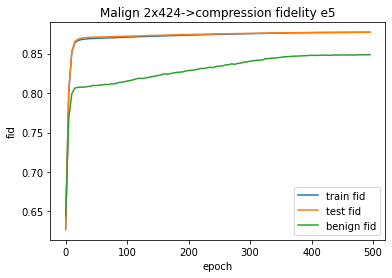

In [34]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist),label="train fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(fid_hist_test),label="test fid")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(benign_fid),label="benign fid")

plt.legend()
plt.title("Malign 2x424->compression fidelity e5",)
plt.xlabel("epoch")
plt.ylabel("fid")

print("fidelity:",fid_hist[-1])

loss: 1.1402768612155705


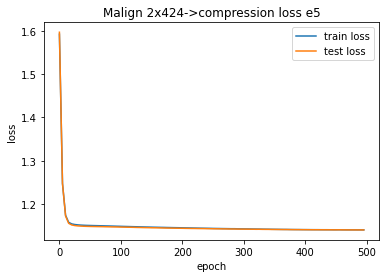

In [35]:
fig = plt.figure()
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist),label="train loss")
plt.plot([x for x in range(0,len(loss_hist)*5,5)],np.array(loss_hist_test),label="test loss")


plt.legend()
plt.title("Malign 2x424->compression loss e5",)
plt.xlabel("epoch")
plt.ylabel("loss")

print("loss:",loss_hist[-1])

## Benign performance 

In [37]:
np_benign = benign.to_numpy()
benign_data = [ torch.tensor([np_benign[i]]) for i in range(len(benign.to_numpy()))]

loss = cost(encoder_params, benign_data )
fidel = fidelity(encoder_params, benign_data )

print("Benign results:")
print("fidelity=",fidel)
print("loss=",loss)


Benign results:
fidelity= 0.8482674497374206
loss= 1.179201693867523


## Classifyer

In [38]:
beningn_flist=[]
for b in benign_data:
    f=fidelity(encoder_params, [b])
    beningn_flist.append(f.item())
    
print(min(beningn_flist))
print(max(beningn_flist))

0.814772335260057
0.8850835613722416


In [39]:
malign_flist=[]
for b in training_data:
    f=fidelity(encoder_params, [b])
    malign_flist.append(f.item())
    
print(min(malign_flist))
print(max(malign_flist))

0.8494620763586773
0.9111891585992302


In [40]:
beningn_flist

[0.8501498784085659,
 0.8488094280226266,
 0.855506220729984,
 0.8450291703186508,
 0.8565805535394873,
 0.8473095927089749,
 0.841971794891615,
 0.8245574336437866,
 0.870068855963084,
 0.8477275537668817,
 0.8583989159513592,
 0.8164767954856313,
 0.8444782754895036,
 0.8307628289429383,
 0.845981793335682,
 0.8556057647441634,
 0.8540631468624222,
 0.8647238753937945,
 0.814772335260057,
 0.8592547221053533,
 0.8499379529602992,
 0.8460069901453474,
 0.8307823331626737,
 0.8353241436754961,
 0.8666688840057231,
 0.8450583506877811,
 0.8850835613722416,
 0.8808648781858633,
 0.8760003494500024,
 0.8474735802428105,
 0.8721171046392867,
 0.8245065740875661,
 0.832446797201401,
 0.8234741293175938,
 0.8502678948536113,
 0.8356584328115987,
 0.8167069762178611,
 0.8672126859451732,
 0.8651692944386232,
 0.8772823625343856,
 0.8538668858893721,
 0.8275010550743933,
 0.8339023836974407,
 0.8394075280239374,
 0.8432505402294277,
 0.8549848842325634,
 0.8451917815108536,
 0.824367279511129,

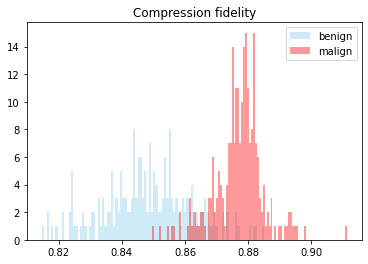

In [41]:
plt.hist(beningn_flist, bins = 100 ,label="benign", color = "skyblue",alpha=0.4)
plt.hist(malign_flist, bins =100 ,label="malign",color = "red",alpha=0.4)
plt.title("Compression fidelity",)
plt.legend()
plt.show()

In [46]:
split=0.866


print("split:",split)
b_e=[]
for i in beningn_flist:
    if i<split:
        b_e.append(1)
    else:
        b_e.append(0)
ab_ac=sum(b_e)/len(b_e)
print("benign classification accuracy:",ab_ac)
m_e=[]
for i in malign_flist:
    if i>split:
        m_e.append(1)
    else:
        m_e.append(0)
am_ac=sum(m_e)/len(m_e)
print("malign classification accuracy:",am_ac)
t_ac=(sum(b_e)+sum(m_e))/(len(b_e)+len(m_e))
print("total accuracy:",t_ac)

split: 0.866
benign classification accuracy: 0.8923076923076924
malign classification accuracy: 0.9098360655737705
total accuracy: 0.9020501138952164


In [42]:
"""
experiment_parameters={"autoencoder":"e2","params":encoder_params}
f=open("Cancer_encoder_e5-SelectedFeautures_params500"+str(epoch)+".txt","w")
f.write(str(experiment_parameters))
f.close()
"""